In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_4010234/3606276056.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [20]:
#install required bioconductor and github packages
bioc = ro.packages.importr('BiocManager') 
remotes = ro.packages.importr('remotes')
utils = ro.packages.importr('utils')
utils.chooseCRANmirror(ind=1)

bioc.install('scran')
bioc.install('BiocParallel')
bioc.install('scry')

remotes.install_github('carmonalab/STACAS') #for integration based on MNNs
remotes.install_github('carmonalab/ProjecTILs') #for annotating Tcell subtypes
bioc.install('UCell')
utils.install_packages('scGate')#for celltype annotation

Update all/some/none? [a/s/n]: 

RRuntimeError: Fehler in if (answer %in% allowed) break : Argument hat Länge 0


In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')
stacas = ro.packages.importr('STACAS')
seurat = ro.packages.importr('Seurat')
scgate = ro.packages.importr('scGate')
Matrix = ro.packages.importr('Matrix')
ProjecTILs = ro.packages.importr('ProjecTILs')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [4]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
# adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Transfer HTOs from count to obs column to avoid influence on SoupX and quality control

In [7]:
adatas_cp = adatas.copy()
adatas, adatas_raw, conditions = dp.transfer_htos(adatas, adatas_cp)

### 3. perform quality control

In [15]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [9]:
# adatas_mad = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas)
# adatas_qc = dp.quality_control(adatas, method = 'qntl')
adatas_qc = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


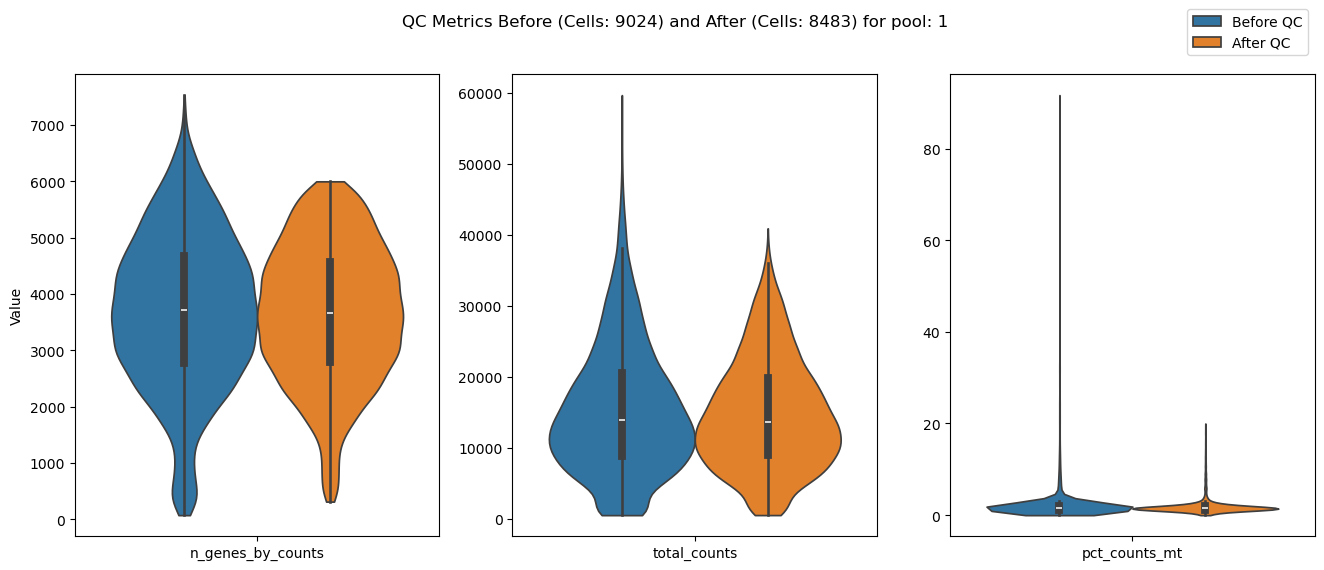

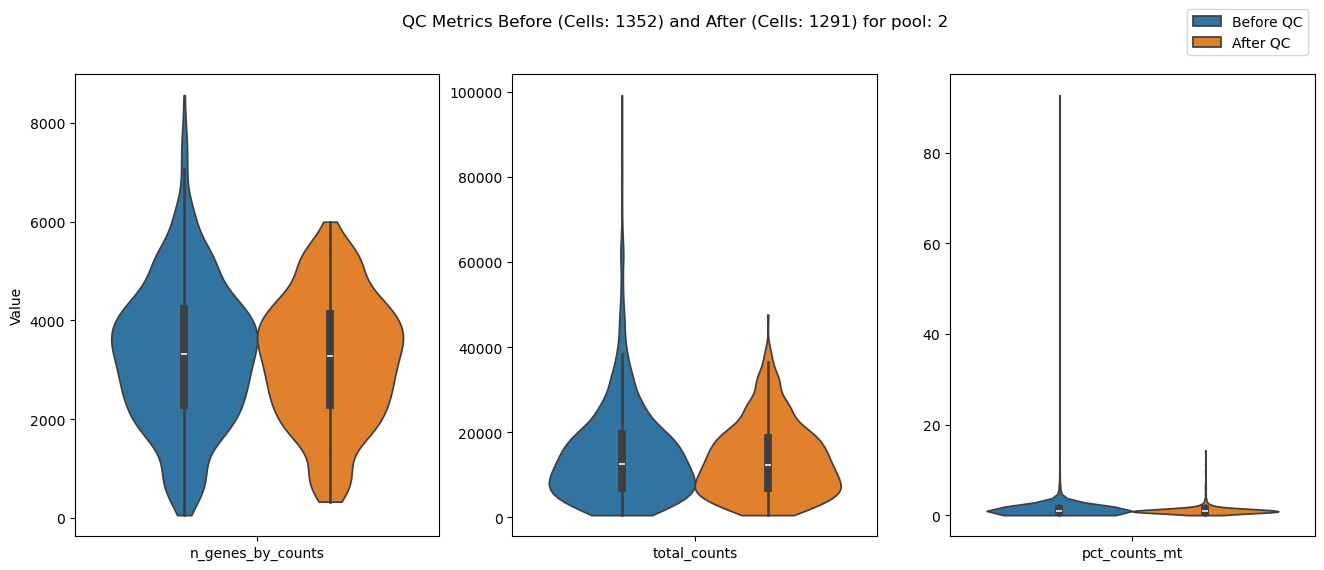

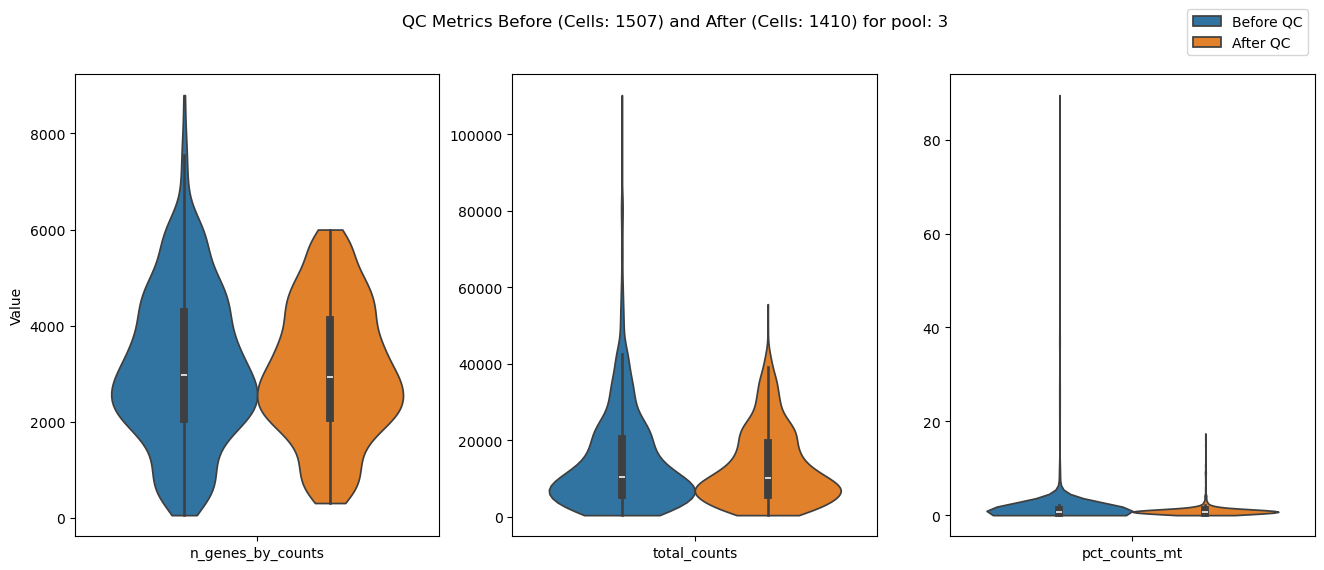

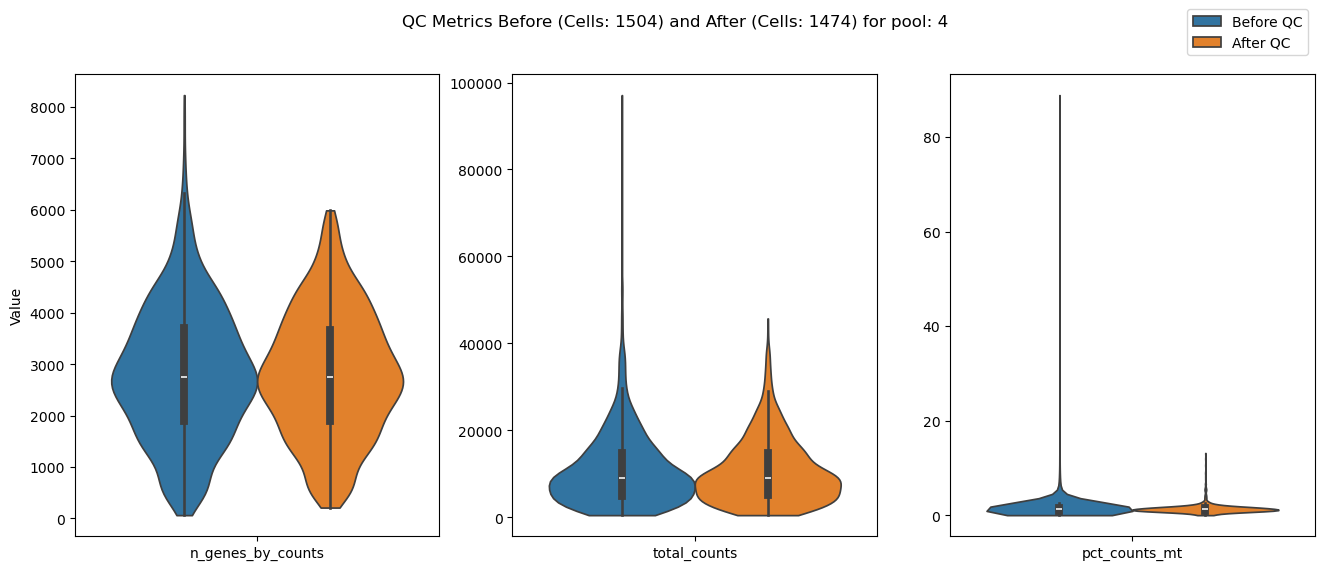

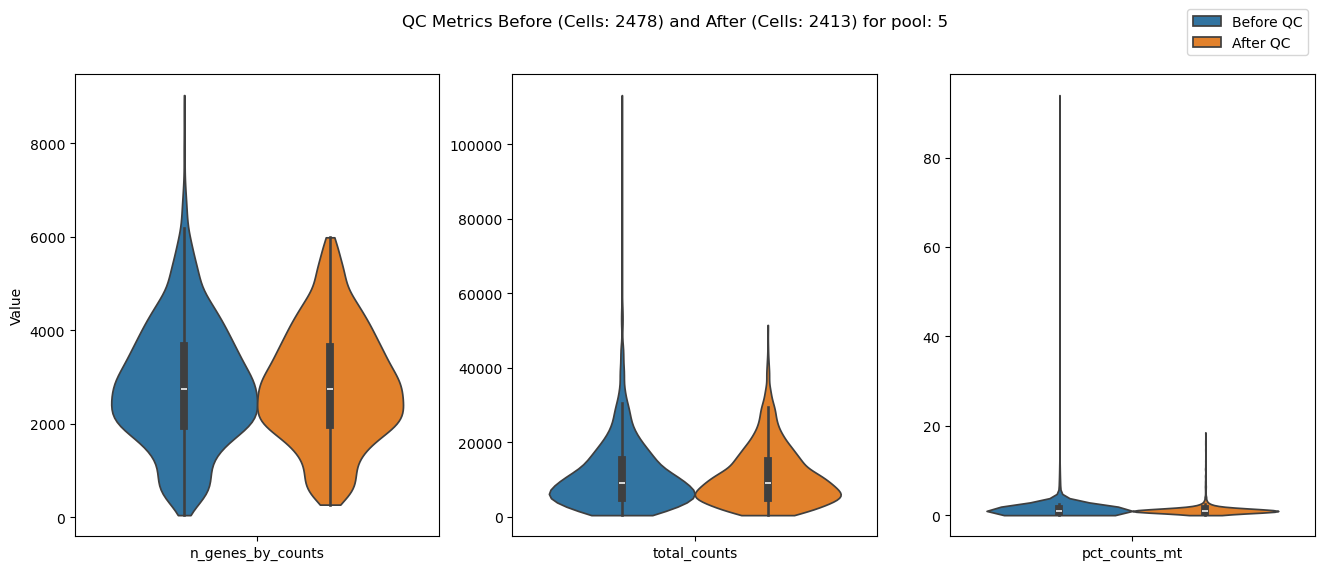

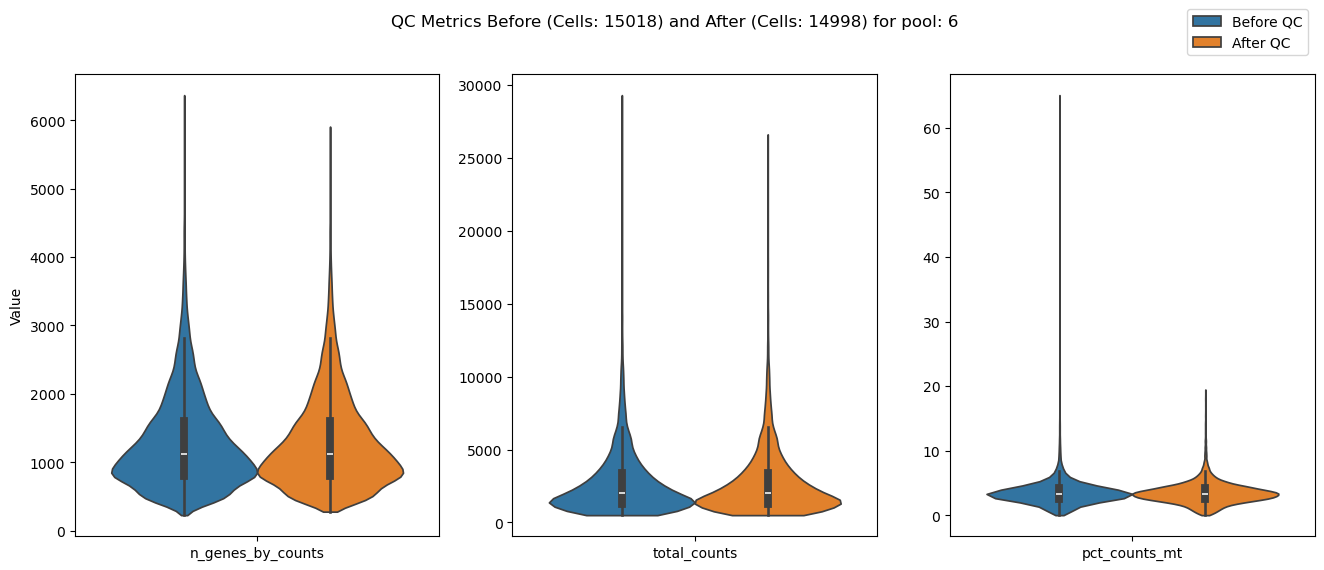

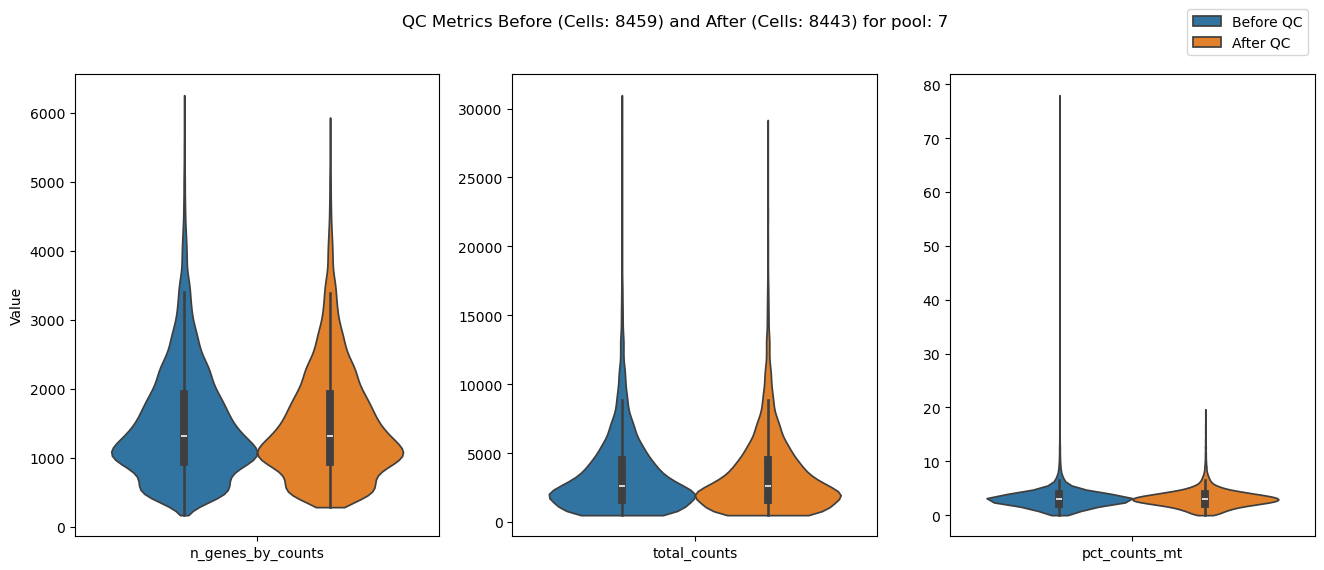

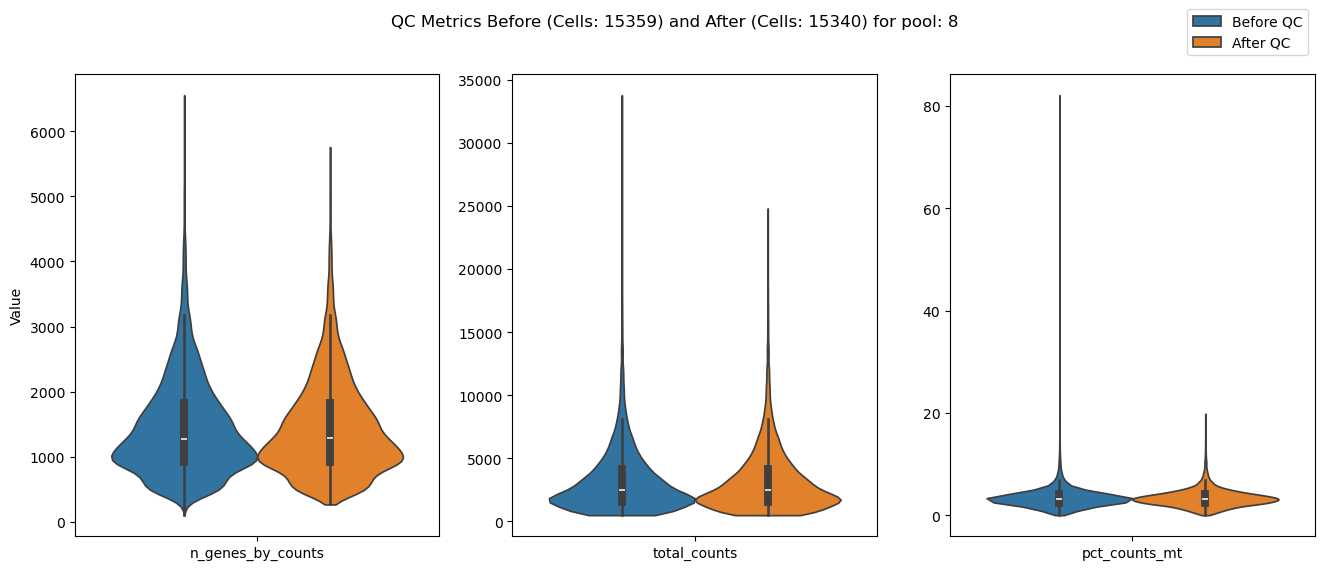

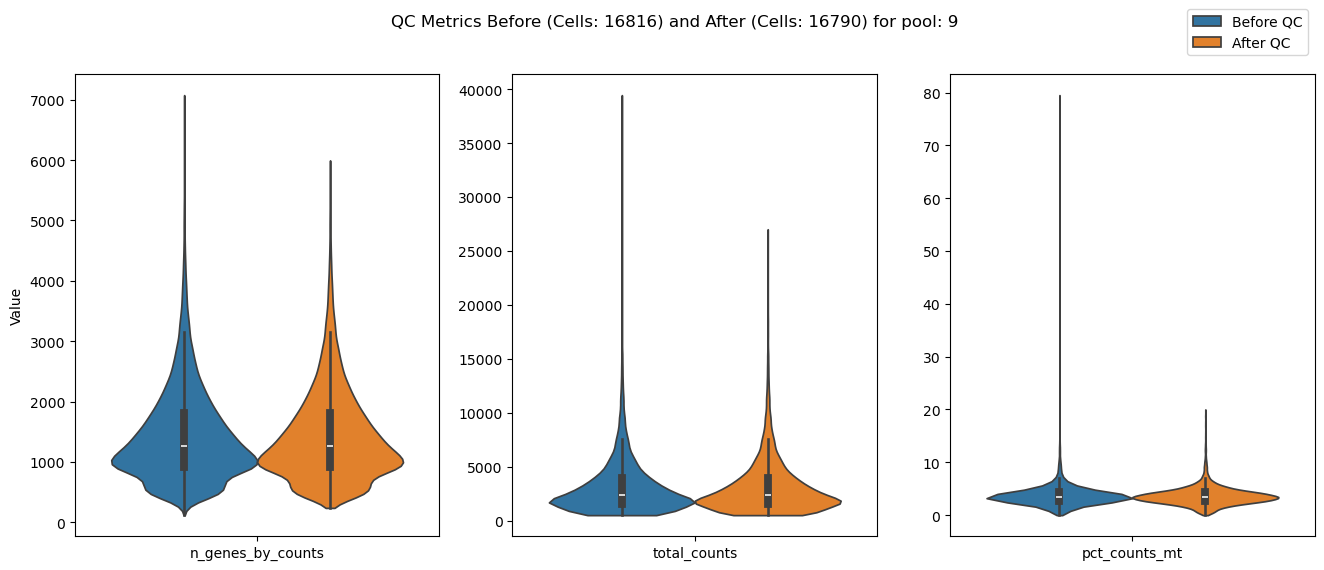

In [10]:
path = './03_results/figures/hashsolo_mad/'
dp.plot_qc_metrics(adatas, adatas_qc) #, save_dir=path

In [11]:
sum([adata.shape[0] for adata in adatas])

71517

### 4. Perform SoupX to correct for ambient mRNA

In [ ]:
groups = [dp.pregroup(adata) for adata in adatas_qc]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas_qc, adatas_raw, groups)]

### 5. Demultiplex the data using hashsolo (needs to be after qc since its based on priot probabilities that assume cells have passed filtering. Also, reasonable after SoupX, since filtering out doublets etc. will affect the soupx clusters)

In [12]:
dp.demultiplex(adatas_qc, conditions)
adatas_singlets = [dp.filter_for_singlets(adata) for adata in adatas_qc]

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [13]:
print("counts after filtering:", [adatas_qc[i].shape[0] for i in range(0, len(adatas))])
print("Doublets:",[sum(adatas_qc[i].obs.Classification == 'Doublet') for i in range(0,len(adatas))])
print("Negatives:",[sum(adatas_qc[i].obs.Classification == 'Negative') for i in range(0,len(adatas))])
print("counts after Demultiplexing:",[sum(adatas_singlets[i].obs.Classification.value_counts()) for i in range(0,len(adatas_singlets))])

counts after filtering: [8483, 1291, 1410, 1474, 2413, 14998, 8443, 15340, 16790]
Doublets: [1065, 49, 51, 67, 126, 1503, 670, 1631, 1676]
Negatives: [19, 7, 9, 0, 0, 25, 15, 28, 29]
counts after Demultiplexing: [7399, 1235, 1350, 1407, 2287, 13470, 7758, 13681, 15085]


### 6. Concatenate/merge all the pools

In [ ]:
#merge andata objects, do not include genes that are not present in all samples (join = 'inner'), set to join = 'outer' if wanting to retain all genes if present in at least one dataset
adata_merged = ad.concat(adatas_singlets, join='inner', label='dataset',index_unique='_')

#there are about 200 dLN cells left after using hashsolo with absolute QC, however there are around 6000 left when using HTODemux
adata_merged = adata_merged[ adata_merged.obs['Classification'].str.contains('d0')| adata_merged.obs['Classification'].str.contains('TIL')].copy()

### 7. Normalize the data using shifter logarithm or scran normalization

In [17]:
scales_counts = sc.pp.normalize_total(adata_merged, target_sum=1e4, inplace=False)
adata_merged.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

In [ ]:
# groups = dp.pregroup(adata_merged, resolution=15)
# adata_merged.layers['scran'] = dp.scran_norm(adata_merged, groups)

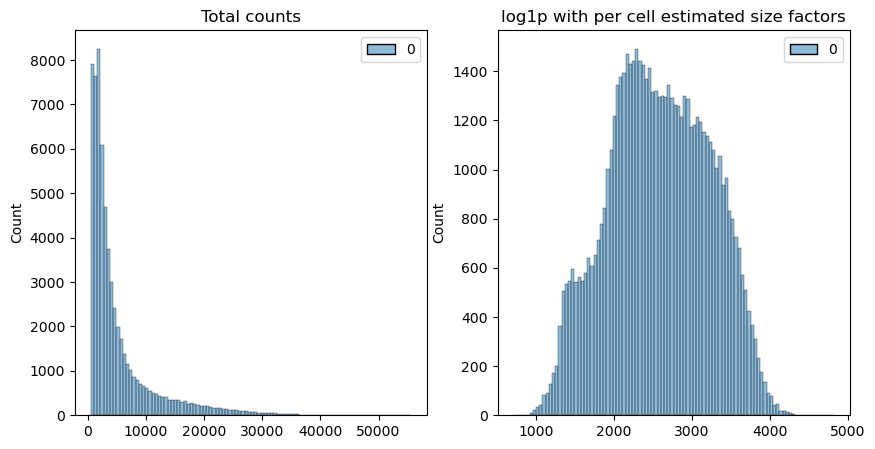

In [18]:
dp.plot_normalization(adata_merged, 'log1p', 'per cell')
# dp.plot_normalization(adata_merged, 'scran', 'scran')

In [19]:
#since scran does not really effectively normalize, we use the shifted logarithm
adata_merged.layers['counts'] = adata_merged.X
adata_merged.X = adata_merged.layers['log1p']

In [15]:
file = './01_data/processed/merged_and_processed/hashsolo_mad_after_norm.h5ad'
adata_merged.write(file, compression='gzip')
# adata_merged = sc.read(file)

### annotate celltypes:

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/s377963/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Blood

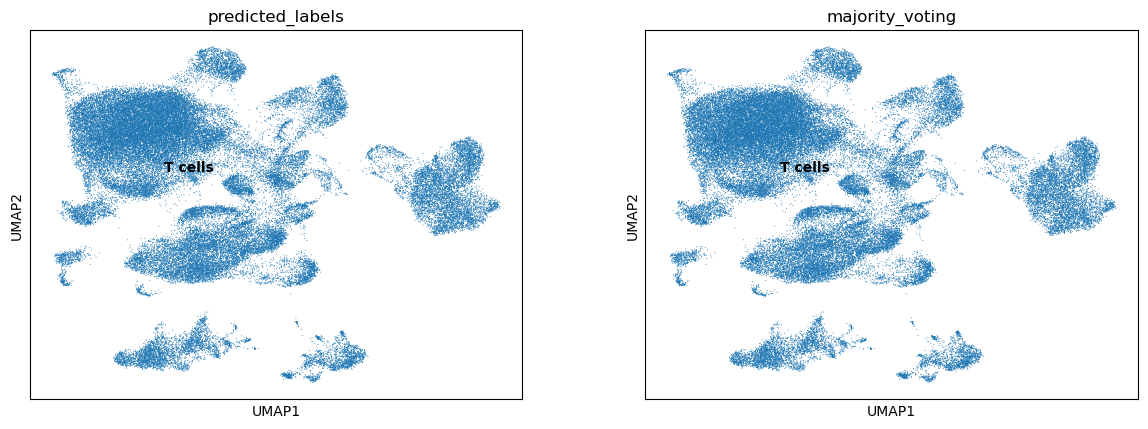

In [ ]:
import celltypist
from celltypist import models

sc.pp.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.tl.leiden(adata_merged, resolution=0.4, flavor="igraph", n_iterations=2)

#download celltypist models
models.download_models(force_update = True)
#select the immune model
model_low = models.Model.load(model = 'Immune_All_Low.pkl')
model_high = models.Model.load(model = 'Immune_All_High.pkl')

predictions_qc = celltypist.annotate(adata_merged, model = model_high, majority_voting = True)
celltypes_qc = predictions_qc.to_adata()

sc.pl.umap(celltypes_qc, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

🔬 Input data has 63472 cells and 33696 genes
🔗 Matching reference genes in the model
🧬 6 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


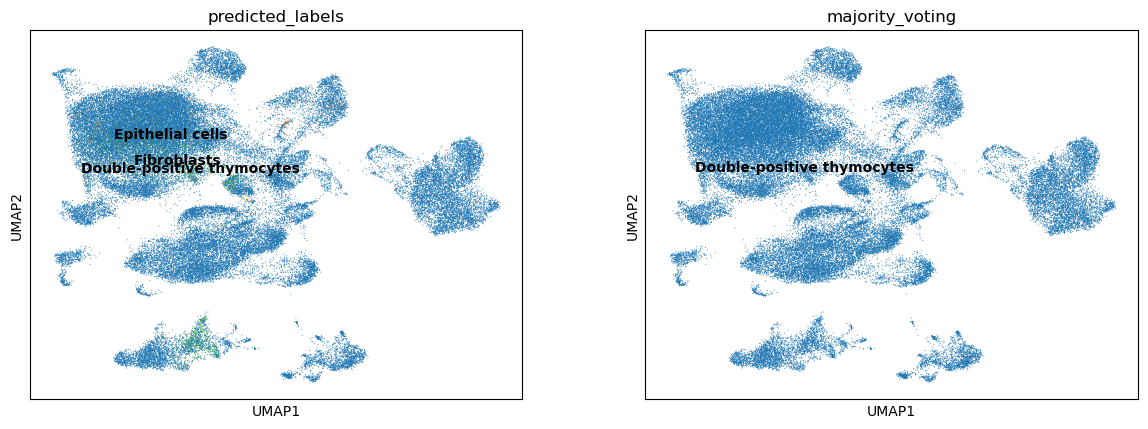

In [21]:
predictions_qc = celltypist.annotate(adata_merged, model = model_low, majority_voting = True)
celltypes_qc = predictions_qc.to_adata()

sc.pl.umap(celltypes_qc, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

### 8. Perform feature selection

In [ ]:
#select only the 2000 most variable genes in a batch aware way (meaning first in each batch 2000 most variable genes are selected and the 2000 genes that are variable in the most datasets are retained)
sc.pp.highly_variable_genes(adata_merged, n_top_genes=3000, flavor="seurat", batch_key='dataset')

#subset merged data based on highly variable genes 
adata_merged_hvg = adata_merged[:, adata_merged.var.highly_variable].copy()

#store the genes selected by the hvg function for later use during integration
anchor_features = adata_merged_hvg.var_names.values
ro.globalenv["anchor_features"] = anchor_features

In [16]:
######
#alternatively with seurat, this yields about 60% the same genes, so its slightly different in selecting variale features, however the end result is extremely similar:
######
#first make the concatenated/merged data available to R 
adata_merged_seurat = adata_merged.copy()
adata_merged_seurat.obs['dataset'] = adata_merged_seurat.obs['dataset'].astype(str)
del adata_merged_seurat.uns
ro.globalenv["adata_merged_seurat"] = adata_merged_seurat

#convert from R singleCellObject into a seurat object and split the datasets into a list. Also rename the assay so it will be recognized by all R functions as the original assay
%R seurat <- as.Seurat(adata_merged_seurat, counts = "counts", data = "log1p") #counts = "soupX_counts" or "counts"
%R seurat <- RenameAssays(seurat, originalexp = "RNA")
%R batch_list <- SplitObject(seurat, split.by = "dataset")

#finally select highly variable genes in a batch aware way in seurat
%R seurat_features <- SelectIntegrationFeatures(batch_list, nfeatures=1000)#, fvf.nfeatures = 3000
%R -o seurat_features

#subset the data based on the highly variable genes selected
adata_merged.var['highly_variable'] = adata_merged.var_names.isin(seurat_features)

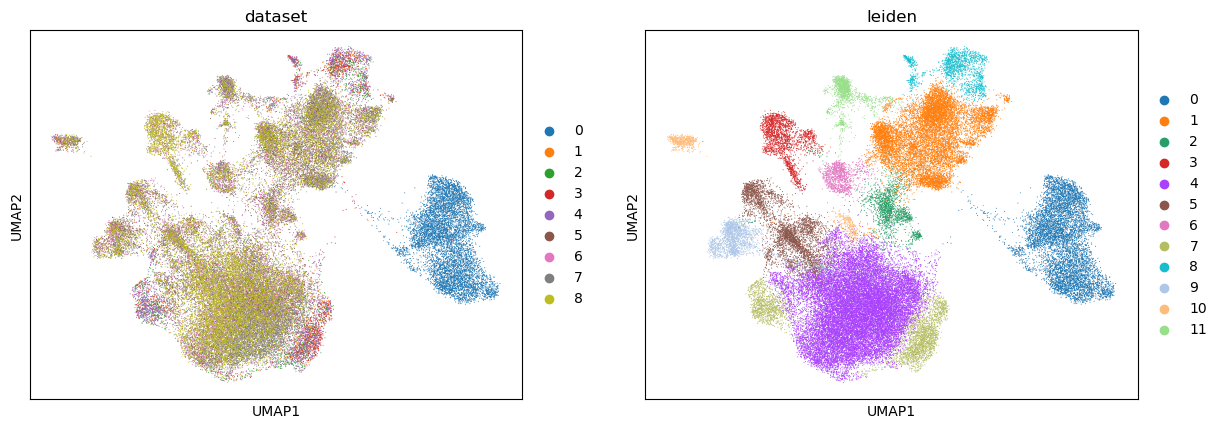

In [18]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged, mask_var="highly_variable")
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.tl.leiden(adata_merged, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged, color=['dataset', 'leiden'])

### 9. Perform data integration using Mutual Nearest Neighbots (since this is a way to effectively change the count matrix and unlike other integration methods, this yields not only a lower dimensional representation of the data)

In [19]:
#STACAS uses normalized counts, in seurats tutoral, they first do NormalizeData() and use seurat integration afterwards
%R integrated <-  Run.STACAS(batch_list, anchor.features = seurat_features, dims = 1:30) #rownames(seurat) for all features, anchor_features for scanpy version, seurat_features for seurat version

%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

# adata_merged_hvg.layers['integrated'] = integrated_expr
# adata_merged_hvg.X = adata_merged_hvg.layers['integrated']
# adata_merged.obsm['integrated'] = integrated_expr

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~26s           |++++++++++++                                      | 22% ~11s           |+++++++++++++++++                                 | 33% ~07s           |+++++++++++++++++++++++                           | 44% ~04s           |++++++++++++++++++++++++++++                      | 56% ~03s           |++++++++++++++++++++++++++++++++++                | 67% ~05s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~03s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=29s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~02m 54s       |+++                                               | 6 % ~02m 46s       |+++++                                             | 8 % ~02

'value'

In [26]:
#sort the integrated data object so that it matches the order within the andata object (currently its sorted according to the order of variability)
highly_variable_mask = adata_merged.var['highly_variable'].values
hvg_genes = adata_merged[:, highly_variable_mask].var_names.tolist()
corrected_positions = [hvg_genes.index(item) for item in seurat_features.tolist()]
integrated_corrected_gene_order = integrated_expr[:, corrected_positions]
adata_merged.obsm['integrated'] = integrated_corrected_gene_order

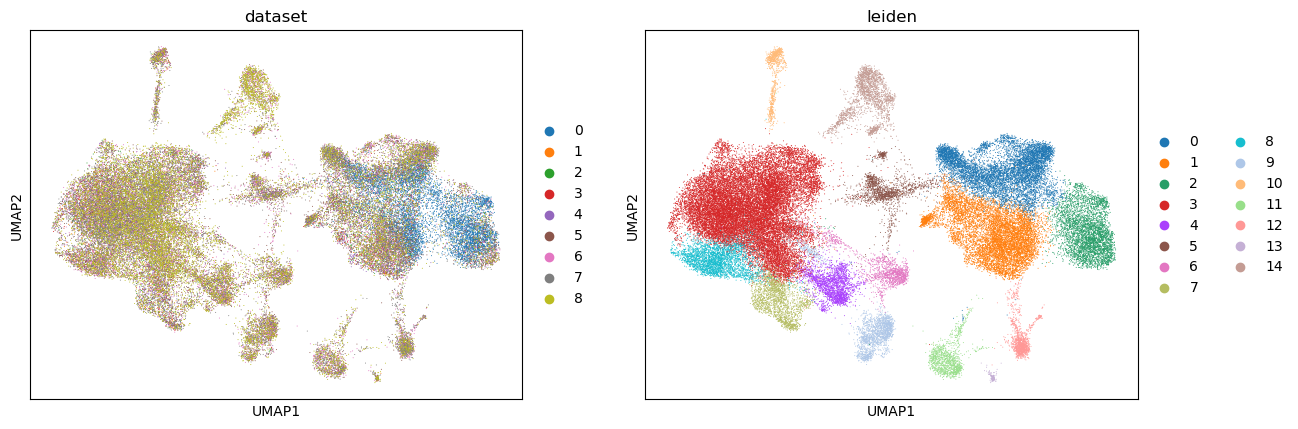

In [27]:
# adata_temp = sc.AnnData(X=integrated_corrected_gene_order, var=adata_merged.var[highly_variable_mask])
pca = sc.tl.pca(integrated_corrected_gene_order)
adata_merged.obsm['X_pca'] = pca
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.tl.leiden(adata_merged, resolution=0.4, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_merged, color=['dataset', 'leiden'])

### 10. Perform Celltype annotation

#### 10.1. ScGate: filtering for pure Tcells

In [28]:
#using scGate, this is based on the seurat object 'integrated' generated before by stacas. If you are using the integrated matrix from python, you will need to specify the new seurat object and remove reduction = "pca" so that scGate itself generates the pca reduction itself
%R sc_gating_models <- get_scGateDB()
%R seurat_object_annotated <- scGate(integrated, model = sc_gating_models$mouse$generic$Tcell, ncores = 4, reduction = "pca", output.col.name = "is.tcell") #, reduction = 'calculate', assay = 'originalexp'
%R annotation <- seurat_object_annotated@meta.data$is.tcell
%R -o annotation

# adata_merged_hvg.obs['is_tcell'] = annotation
# sum(adata_merged_hvg.obs.is_tcell == 'Pure')
adata_merged.obs['is_tcell'] = annotation
sum(adata_merged.obs.is_tcell == 'Pure')

  |======================================================================| 100%

  |======================================================================| 100%



18830

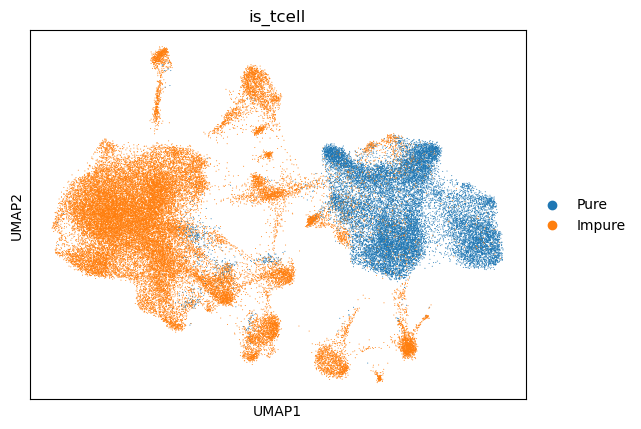

In [29]:
sc.pl.umap(adata_merged, color='is_tcell')

In [30]:
adata_merged.write('01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated.h5ad', compression='gzip')
# adata = sc.read('./01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad')

#### 10.2 ProjectTILs: annotating Tcells subtypes

In [ ]:
#download the reference datasets to map to
%R download.file("https://figshare.com/ndownloader/files/41414556", destfile = "01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R download.file("https://figshare.com/ndownloader/files/39012395", destfile = "01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")

'value'

In [31]:
%R ref.CD8 <- load.reference.map("01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R ref.CD4 <- load.reference.map("01_data/reference_datasets_project_TILs/CD4T_human_ref_v1.rds")
%R DefaultAssay(ref.CD8) <- "integrated"
%R DefaultAssay(ref.CD4) <- "integrated"

[1] "Loading Custom Reference Atlas..."


[1] "Loaded Custom Reference map Human CD8 TILs"
[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map custom_reference"


'value'

In [32]:
%R print(seurat_object_annotated)

An object of class Seurat 


34696 features across 59298 samples within 2 assays 
Active assay: integrated (1000 features, 1000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 1 dimensional reduction calculated: pca


'value'

In [33]:
adata_pure = adata_merged[adata_merged.obs['is_tcell'] == 'Pure']
scales_counts = sc.pp.normalize_total(adata_pure, target_sum=1e4, inplace=False, layer='counts') #soupX_counts, counts
adata_pure.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

%R ncores <- 8
%R pure_cells <- subset(seurat_object_annotated, subset = is.tcell == "Pure")
%R DefaultAssay(pure_cells) <- "RNA"
%R pure_cells <- NormalizeData(pure_cells)
%R pure_cells_CD8 <- ProjecTILs.classifier(query = pure_cells, ref = ref.CD8, ncores = ncores) # , split.by = "dataset" filter.cells = FALSE, skip.normalize=TRUE,
%R pure_cells_CD8_CD4 <- ProjecTILs.classifier(query = pure_cells_CD8, ref = ref.CD4, ncores = ncores, overwrite=FALSE) # , overwrite=FALSE
%R TC_annotations <- pure_cells_CD8_CD4@meta.data$functional.cluster
%R -o TC_annotations 

adata_pure.obs['Tcell_subtype'] = TC_annotations

/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  |                                                                      |   0%[1] "Using assay RNA for query"
[1] "8734 out of 18830 ( 46% ) non-pure cells removed. Use filter.cells=FALSE to avoid pre-filtering"
[1] "Transforming expression matrix into space of orthologs"
[1] "Aligning query to reference map for batch-correction..."
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~08s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=15s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=39s  

Projecting corrected query onto Reference PCA space

Projecting corrected query onto Reference UMAP space
  |======================================================================| 100%

  |                                                                      |   0%[1] "Using assay RNA for query"
[

In [34]:
%R print(table(pure_cells_CD8_CD4$functional.cluster, useNA = "ifany"))
pure_cells = sum(adata_merged.obs['is_tcell'] == 'Pure')
not_annotated_cells = sum(pd.isnull(adata_pure.obs.Tcell_subtype))
diff = pure_cells - not_annotated_cells
print(f'Pure Cells: {pure_cells}')
print(f'From which {not_annotated_cells} could not be annotated')
print(f'{diff} were annotated')


CD4.CTL_EOMES   CD4.CTL_Exh  CD4.CTL_GNLY CD4.NaiveLike       CD4.Tfh 
           10           169            15           104           536 
     CD4.Th17      CD4.Treg        CD8.CM        CD8.EM CD8.NaiveLike 
          856           679           289           810           106 
    CD8.TEMRA       CD8.TEX      CD8.TPEX          <NA> 
            1          4434          4456          6365 
Pure Cells: 18830
From which 6365 could not be annotated
12465 were annotated


In [37]:
result = (
    adata_pure.obs.groupby('dataset')['Tcell_subtype']
    .value_counts()
    .unstack(fill_value=0)  # Optional: Unstack to get a table format
)

/tmp/ipykernel_234756/689621076.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_pure.obs.groupby('dataset')['Tcell_subtype']


In [38]:
result

Tcell_subtype,CD4.CTL_EOMES,CD4.CTL_Exh,CD4.CTL_GNLY,CD4.NaiveLike,CD4.Tfh,CD4.Th17,CD4.Treg,CD8.CM,CD8.EM,CD8.NaiveLike,CD8.TEX,CD8.TPEX
dataset,,,,,,,,,,,,
0,0,12,0,37,79,597,163,10,55,7,1790,2591
1,0,1,1,0,7,1,14,5,6,1,130,67
2,0,0,0,0,10,14,21,21,9,6,179,57
3,1,1,0,2,2,1,6,10,12,0,210,68
4,2,0,3,1,12,17,41,17,11,4,284,89
5,4,33,7,34,75,41,222,38,248,17,517,492
6,1,15,3,19,39,40,118,23,103,7,271,220
7,5,30,6,45,74,48,161,72,277,39,660,543
8,7,19,6,22,72,67,183,41,210,10,405,468


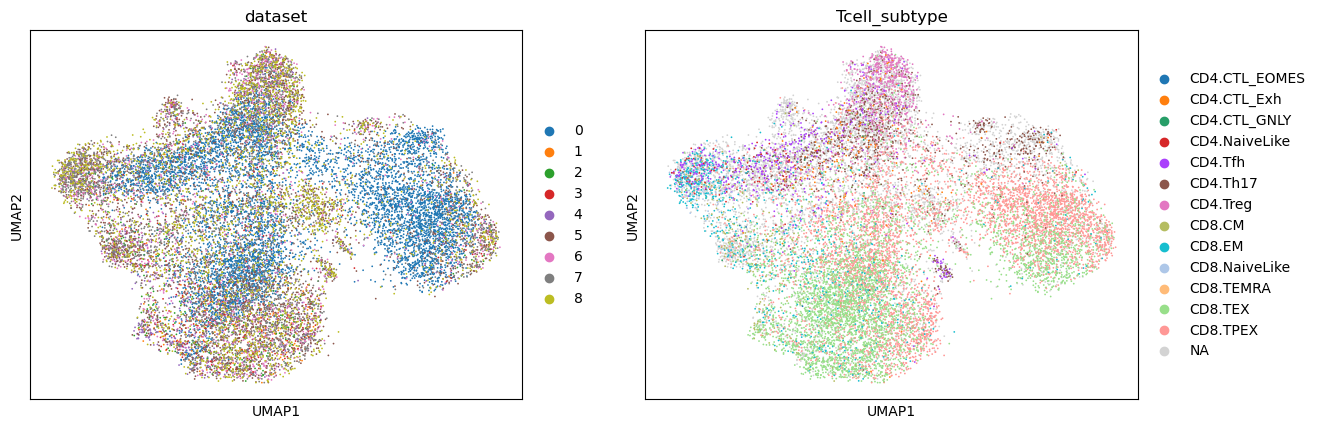

In [35]:
pca = sc.tl.pca(adata_pure.obsm['integrated'])
adata_pure.obsm['X_pca'] = pca
sc.pp.neighbors(adata_pure)
sc.tl.umap(adata_pure)
sc.tl.leiden(adata_pure, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_pure, color=['dataset', 'Tcell_subtype'])

### 11. Save the progress

In [36]:
adata_pure.write('01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated_TCsubtypes.h5ad', compression='gzip') #takes forever 